In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import community
import statistics
import scipy.stats as stats
from os import listdir
from datetime import datetime, date, timedelta
import pickle

In [2]:
working_dir = '/media/eg15396/EG_DATA-7/NTM/'
myrm_list = sorted([ s for s in listdir(working_dir) if s[15:17] == '.m'])

In [3]:
# function to compute netowrk properties
def G_prop(G, start, time_win, max_gap, name):
    
    # compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    GC = G.subgraph(Gcc[0])
    
    # Best partition Louvian Method
    best_partition = community.best_partition(G, weight='weight', randomize=False)
    best_partition_CC = community.best_partition(GC, weight='weight', randomize=False)
    return {'rep': int(name[8:10]),
            'exp': name[11:15],
            'start': fm.Time.ToDateTime(start), 
            'time_win': time_win, 
            'max_gap': max_gap,
            'GC': GC.number_of_nodes(),
            'ants': G.number_of_nodes(),
            'partition': np.max(list(best_partition_CC.values())) + 1,
            'MOD': community.modularity(best_partition, G),
            'cMOD': community.modularity(best_partition_CC, GC),
            'DEN': nx.density(G), 
            'wDEN': nx.adjacency_matrix(G).sum() / (G.number_of_nodes() * (G.number_of_nodes() - 1) * time_win),  # weighted density = sum all weights /(|V|*(|V|-1)/2 * time_win)
            'DIA': nx.diameter(GC),
            'wDIA': nx.diameter(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'RAD': nx.radius(GC),
            'wRAD': nx.radius(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            'DEH': np.std([G.degree(n) for n in G.nodes()]),
            'cDEH': np.std([GC.degree(n) for n in GC.nodes()]),
            'wDEH': np.std(nx.adjacency_matrix(G).sum(axis=0)), # strength heterogeneity
            'cwDEH': np.std(nx.adjacency_matrix(GC).sum(axis=0)), # strength heterogeneity
            'CLS': np.mean([c for c in nx.clustering(G, weight='weight').values()]) 
            }

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),fm.Time.Now(),1,1,myrm_list[0]).keys())

In [4]:
# Function to compute the cumulative interaction function
def compute_G(exp, start, end, min_cum_duration, frm_rate):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        
        # Focus on Nest zone (id=1)
        if (1 in i.Trajectories[1].Zones):
                
            # OPT1
            # WEIGHTS: cumulative interaction time
            #adj_mat[i.IDs[0]-1, i.IDs[1]-1] += (TimeToFrame[fm.Time.ToTimestamp(i.End)] - TimeToFrame[fm.Time.ToTimestamp(i.Start)]) * 1 / frm_rate
        
            # OPT2
            # WEIGHTS: number of interactions
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] += 1
                    

    # interaction filtering (remove weak connections)
    adj_mat[adj_mat <  min_cum_duration] = 0

    # network build
    G = nx.Graph(adj_mat)

    # store inverse of weights
    nx.set_edge_attributes(G, 
                           {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
                           'inv_weight')
    return G



In [5]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# maximum gap (s) for interaction computation
for max_gap in [10]:

    print(max_gap)
    
    # minimum cumulative interaction duration (s)
    min_cum_duration = 0 


    ## ============================ 


    for myrm_file in myrm_list[20:]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)

        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)


        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")


        # ======== 12H window ========
        #print('12h slot')
        # cumulative time window (s)
        time_win = 60 * 60 * 12

        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  #to do: double check time shift
        end = start.Add(fm.Duration(time_win * 10**9))

        # Compute network
        #G = compute_G(exp, start, end, min_cum_duration, frm_rate)

        # Compute properties
        #prop_df = prop_df.append(G_prop(G, start, time_win, max_gap, myrm_file), ignore_index=True)

#         # ======== 1H window ========
#         time_win = 60 * 60 * 1
#         for tw in range(12):
#             print('1h slot ' + str(tw + 1))
#             s = start.Add(fm.Duration(tw * time_win * 10**9))
#             e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

#             # Compute network
#             G = compute_G(exp, s, e, min_cum_duration, frm_rate)

#             # Compute properties
#             prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
            
            
        
        # ======== 2H window ========
        time_win = 60 * 60 * 2
        for tw in range(6):
            #print('2h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
            
            

#         # ======== 4H window ========
#         time_win = 60 * 60 * 0.5
#         for tw in range(24):
#             print('0.5h slot ' + str(tw + 1))
#             s = start.Add(fm.Duration(tw * time_win * 10**9))
#             e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

#             # Compute network
#             G = compute_G(exp, s, e, min_cum_duration, frm_rate)

#             # Compute properties
#             prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)



# Save
a_file = open("data/prop_data_2_ni_NEST.pkl", "wb")
pickle.dump(prop_df, a_file)
a_file.close()

prop_df

10
EG_NTM_s13_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s13_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s14_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s14_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s15_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s15_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s16_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s16_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s17_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s17_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s18_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s18_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s19_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s19_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s20_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s20_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s21_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s21_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s22_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s22_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s23_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s23_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s24_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s24_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s25_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s25_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s26_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s26_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s27_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s27_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s28_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s28_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s29_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s29_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s30_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s30_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s31_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s31_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s32_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s32_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s33_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s33_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s34_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s34_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s35_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s35_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s36_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s36_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s37_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s37_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s38_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s38_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s39_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s39_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s40_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s40_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s42_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s42_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s43_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s43_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s44_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s44_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s45_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s45_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s46_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s46_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s47_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s47_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s48_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s48_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s49_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s49_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s50_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s50_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s51_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s51_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s52_DENa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s52_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s53_DIAa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s53_DIAb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s54_MODa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s54_MODb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s55_DEHa.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

EG_NTM_s55_DEHb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


EG_NTM_s56_DENb.myrmidon


/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
/tmp/ipykernel_4632/857740418.py:74: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, 

,rep,exp,start,time_win,max_gap,GC,ants,partition,MOD,cMOD,...,wDEN,DIA,wDIA,RAD,wRAD,DEH,cDEH,wDEH,cwDEH,CLS
0,13,DEHa,2021-09-12 09:00:00,7200,10,162,177,4,0.197787,0.20001,...,0.000238,4,2.264881,2,1.166667,39.016448,34.070189,213.74037,201.769824,0.03571
1,13,DEHa,2021-09-12 11:00:00,7200,10,162,177,5,0.165605,0.167509,...,0.000243,4,3.111111,2,2.0,39.454048,34.821451,239.604876,230.536048,0.043898
2,13,DEHa,2021-09-12 13:00:00,7200,10,156,177,4,0.170116,0.169114,...,0.000237,4,2.317816,2,1.19,39.434626,34.075635,248.068041,236.640329,0.046902
3,13,DEHa,2021-09-12 15:00:00,7200,10,154,177,6,0.18827,0.193044,...,0.000212,4,2.191667,2,1.130252,39.041837,34.319577,215.362863,202.425445,0.038844
4,13,DEHa,2021-09-12 17:00:00,7200,10,155,177,7,0.177124,0.178932,...,0.000236,4,2.333333,2,1.166667,40.536379,34.743906,238.767013,225.055591,0.047918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,56,DENb,2021-12-20 11:00:00,7200,10,159,172,5,0.231618,0.229238,...,0.000346,3,2.142857,2,1.076923,39.388541,33.233898,239.527114,214.596972,0.037914
512,56,DENb,2021-12-20 13:00:00,7200,10,157,172,5,0.255005,0.253713,...,0.000332,4,3.144543,2,2.0,38.695036,32.601515,246.291833,221.385623,0.036236
513,56,DENb,2021-12-20 15:00:00,7200,10,158,172,6,0.194417,0.193786,...,0.000358,3,2.22619,2,1.135965,40.340105,32.207388,254.800303,227.84098,0.048218
514,56,DENb,2021-12-20 17:00:00,7200,10,159,172,5,0.229176,0.229176,...,0.000333,4,2.19697,2,1.125,38.933141,32.108105,231.224435,207.300215,0.042389


In [7]:
prop_df.wDEN

0      0.000238
1      0.000243
2      0.000237
3      0.000212
4      0.000236
         ...   
511    0.000346
512    0.000332
513    0.000358
514    0.000333
515    0.000338
Name: wDEN, Length: 516, dtype: object

In [258]:
# Open Pickle data

a_file = open("data/prop_data_12h_4h.pkl", "rb")
df = pickle.load(a_file)
df

,rep,exp,start,time_win,CC,ants,partition,MOD,DEN,wDEN,DIA,wDIA,RAD,wRAD,DEH,wDEH,CLS
0,13,DEHa,2021-09-12 09:00:00,43200,1,177,3,0.265934,0.964432,0.004569,2,0.005756,1,0.003515,7.920525,11376.651457,0.017645
1,13,DEHa,2021-09-12 09:00:00,14400,1,177,4,0.314675,0.805727,0.004812,2,0.013881,1,0.008613,22.507434,4459.552219,0.006845
2,13,DEHa,2021-09-12 13:00:00,14400,1,177,5,0.288999,0.79218,0.004316,2,0.018524,1,0.009419,24.481888,4023.410278,0.010674
3,13,DEHa,2021-09-12 17:00:00,14400,1,177,4,0.293203,0.810927,0.004576,2,0.013834,1,0.008749,23.435623,4643.090357,0.005611
4,13,DEHb,2021-09-10 09:00:00,43200,1,186,3,0.24222,0.966289,0.005501,2,0.005506,1,0.003833,8.186532,17266.894913,0.019331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,56,DENa,2021-12-22 17:00:00,14400,1,170,6,0.303259,0.785103,0.00719,2,0.012147,1,0.006513,25.351511,5673.870481,0.012476
348,56,DENb,2021-12-20 09:00:00,43200,1,172,3,0.18531,0.98504,0.007974,2,0.00402,1,0.002479,4.145899,14897.345335,0.04447
349,56,DENb,2021-12-20 09:00:00,14400,1,172,5,0.242208,0.832041,0.008077,2,0.009572,1,0.006048,21.701276,5845.620486,0.017827
350,56,DENb,2021-12-20 13:00:00,14400,1,172,5,0.252718,0.830409,0.008147,2,0.00811,1,0.005179,21.781153,5613.886605,0.022328


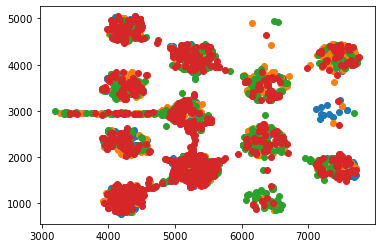

In [45]:
# Zooning TEST
myrm_file = myrm_list[-2]

min_cum_duration = 0
frm_rate = 6
max_gap = 10


exp = fm.Experiment.Open(working_dir + myrm_file)
start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
             timedelta(days = -1)).strftime("%Y-%m-%d")

# ======== 12H window ========

# cumulative time window (s)
time_win = 60 * 60 * 0.05

for t in range(4):
    start_g = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  #to do: double check time shift
    start = start_g.Add(fm.Duration(t * time_win * 10**9))
    end = start.Add(fm.Duration(time_win * 10**9))
    

    N_ants = len(exp.Ants)

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    #TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}
    Q_int = fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(10*10**9),
                                            reportFullTrajectories= False)
    #G = compute_G(exp, start, end, min_cum_duration, frm_rate)


    # compute connencted components
    #Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    #GC = G.subgraph(Gcc[0])
    
    #plt.figure()
    #nx.draw(GC)
    #plt.title(GC.number_of_nodes())
    l1 = []
    for a in Q_int[1]:
        if not(2 in a.Trajectories[1].Zones):
            l1.append(a.Trajectories[1].Mean[:2])
            
            
    
    l1 = np.array(l1)
    plt.scatter(l1[:,0],l1[:,1])
    

In [98]:
# function to compute propagation times expansion coefficients
#def PTEC(exp, start, end, frm_rate):

start = s
end = e

# Number of ants
N_ants = len(exp.Ants)    

focal_ant = 2

prop_tree = [[{1}],[0]]

# # initialise adj-matrix
first_contact_mat = np.ones((N_ants, N_ants)) * np.inf

# # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

# # # Populate network
for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                        reportFullTrajectories= False)[1]:
    # Focus on Nest zone (id=1)
    if (1 in i.Trajectories[1].Zones) & (len(prop_tree[0][-1].intersection(set(i.IDs))) == 1) & (TimeToFrame[fm.Time.ToTimestamp(i.Start)] >= prop_tree[1][-1]):
            prop_tree[0].append(prop_tree[0][-1].union(set(i.IDs)))
            prop_tree[1].append(TimeToFrame[fm.Time.ToTimestamp(i.Start)])
        
# # interaction filtering (remove weak connections)
# adj_mat[adj_mat <  min_cum_duration] = 0

# # network build
# G = nx.Graph(adj_mat)

# # store inverse of weights
# nx.set_edge_attributes(G, 
#                        {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
#                        'inv_weight')
# return G

prop_tree

[[{1},
  {1, 156},
  {1, 4, 156},
  {1, 4, 90, 156},
  {1, 4, 90, 107, 156},
  {1, 4, 55, 90, 107, 156},
  {1, 4, 55, 77, 90, 107, 156},
  {1, 4, 36, 55, 77, 90, 107, 156},
  {1, 4, 36, 55, 77, 90, 107, 110, 156},
  {1, 4, 36, 55, 77, 90, 107, 110, 156, 172},
  {1, 4, 36, 55, 64, 77, 90, 107, 110, 156, 172},
  {1, 4, 36, 55, 64, 77, 90, 107, 110, 156, 165, 172},
  {1, 4, 36, 55, 64, 77, 90, 107, 110, 116, 156, 165, 172},
  {1, 4, 36, 55, 64, 77, 90, 107, 110, 116, 156, 161, 165, 172},
  {1, 4, 18, 36, 55, 64, 77, 90, 107, 110, 116, 156, 161, 165, 172},
  {1, 4, 18, 36, 55, 64, 77, 90, 107, 108, 110, 116, 156, 161, 165, 172},
  {1, 4, 18, 36, 55, 64, 77, 90, 107, 108, 110, 116, 156, 161, 164, 165, 172},
  {1,
   4,
   18,
   36,
   55,
   64,
   77,
   90,
   107,
   108,
   110,
   116,
   133,
   156,
   161,
   164,
   165,
   172},
  {1,
   4,
   18,
   36,
   55,
   64,
   77,
   90,
   107,
   108,
   110,
   116,
   133,
   149,
   156,
   161,
   164,
   165,
   172},
  {1,
   4

/tmp/ipykernel_4632/397941628.py:48: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/(y[1:]*np.diff(x)))


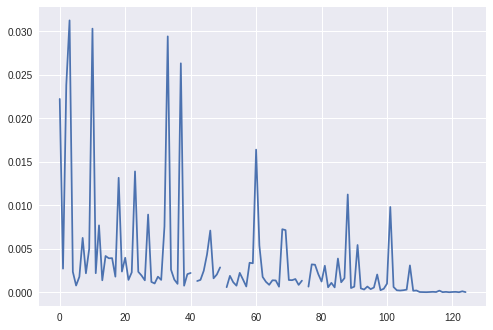

In [97]:
import itertools
from datetime import timedelta
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("seaborn")
import pandas as pd
from sklearn.linear_model import LinearRegression

def linear_regression(x, y):
    """ Find the coefficients of the linear function  y=ax + b,  
        using a linear regression.
    """
    X = x.reshape(-1, 1) 
    reg = LinearRegression(fit_intercept=True, normalize=True)
    _ = reg.fit(X, y)
    a = reg.coef_[0]
    b = reg.intercept_
    y_hat = a * x + b
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    _ = plt.plot(x, y, 'o')
    _ = plt.plot(x, y_hat, '-', label='Linear regression')
    _ = ax.set_xlabel('D(t)')
    _ = ax.set_ylabel('Ratios of slopes to function values')
    _ = ax.legend()
    return a, b

def plot_t0(a, b, country, death_min=0, death_max=None, t0=0):
    """ Find a value of t0 such that the logistic curve is as close 
        as possible to the data on the given interval.
    """
    k = b
    L = -b / a
    country = country[country > death_min]
    if death_max is not None:
        country = country[country < death_max]
    logis = L / (1. + np.exp(-k * (np.arange(len(country)) - t0)))
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    _ = plt.plot(logis, 'o')
    _ = plt.plot(country.values, 'd')
    return L, k


x = np.array(prop_tree[1][1:])
y = np.array(range(len(x)))

plt.plot(1/(y[1:]*np.diff(x)))




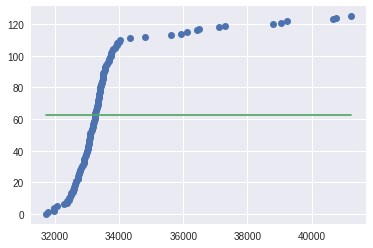

array([54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54., 54.,
       54., 54., 54., 54., 54., 54., 54., 54., 54.])

In [101]:
import scipy.optimize as opt

x = np.array(prop_tree[1][1:])
y = np.array(range(len(x)))

def f(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b
popt, pcov = opt.curve_fit(f, x, y, method="trf")
y_fit = f(x, *popt)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y, 'o')
ax.plot(x, y_fit, '-')
plt.show()

#plt.plot(x, y)
#plt.plot(x, logistic(x))
#plt.yscale('log')
#plt.xlim([prop_tree[1][1],34000])
logistic(x)